A Jupyter notebook for analyzing the differences between predicted and experimental structures.

In [76]:
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from pandas.plotting import table
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys
import scienceplots


Quick look at our data.

In [77]:
cl = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')
rmsd = pd.read_csv('./project_pipeline/data/rmsds.tsv', sep='\t').astype('object')
cl.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,conformation,state,organism,date,notes
0,A0A0R4I961,6gtv,155-279,3-147,1.45,100.0,100.0,1.673,1.135,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
1,A0A0R4I961,6gtz,155-279,3-147,1.631,100.0,100.0,1.648,3.014,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
2,A0A0R4I961,6gu0,155-279,3-147,2.105,100.0,100.0,1.788,4.298,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
3,B5XAZ0,7bfk,116-120,1-115,4.781,100.0,83.478261,2.6,0.965,Closed,Autoinhibited,Salmo salar,['2021-01-04'],NaN
4,B5XAZ0,7bfl,116-120,1-115,2.591,100.0,79.130435,2.76,0.807,Closed,Autoinhibited,Salmo salar,['2021-01-04'],NaN


In [78]:
plt.style.use('science')

We'll re-format the data first.

In [79]:
# Reformat the data for plotting

# Add 1_aligned to classified files
rmsdSub = rmsd[['uniprot', 'pdb', '1_aligned']]
cl = cl.merge(rmsdSub, on=['uniprot', 'pdb'], how='left')

# Select only proteins with both state and conformation annotated
cl = cl.dropna(subset=['state', 'conformation'])
 
# Let's check the length of that
print(len(cl))

# Select columns of interest
clSub = cl[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
clSub.columns = ['Uniprot', 'PDB', 'Autoinhibitory Protein Structure', 'IM on IM', 'FD on FD', 'IM on FD']

# Melt the data
plot = pd.melt(clSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
plot['RMSD'] = plot['RMSD'].astype(float)

# Remove outliers above 100 RMSD
plot = plot[plot['RMSD'] < 100]

551


First let's look at the distributions for RMSD between whole proteins, inhibitory modules, and functional domains.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory Protein Structure vs. IM on IM: Mann-Whitney-Wilcoxon test two-sided, P_val:9.060e-06 U_stat=1.743e+05
IM on IM vs. FD on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.176e-20 U_stat=1.995e+05
FD on FD vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.726e-50 U_stat=7.269e+04
Autoinhibitory Protein Structure vs. FD on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.451e-71 U_stat=2.456e+05
IM on IM vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:7.954e-15 U_stat=1.101e+05
Autoinhibitory Protein Structure vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.058e-03 U_stat=1.356e+05


(<Axes: title={'center': 'Distributions of RMSD values of structural alignments'}, xlabel='Alignment', ylabel='RMSD'>,
  <statannotations.Annotation.Annotation at 0x7fcdb8343510>])

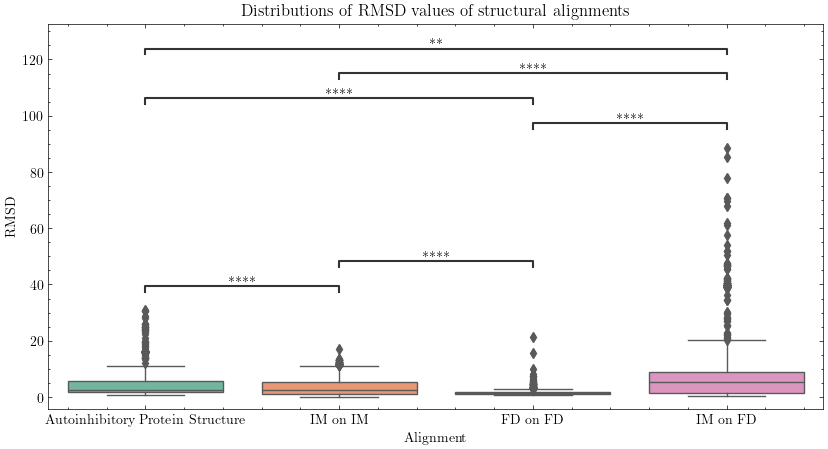

In [80]:
# Now plot it
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=plot, x='Alignment', y='RMSD', ax=ax, palette='Set2')
ax.set_title('Distributions of RMSD values of structural alignments')

# Add the annotations
pairs = [('Autoinhibitory Protein Structure', 'IM on IM'),
         ('Autoinhibitory Protein Structure', 'FD on FD'),
         ('Autoinhibitory Protein Structure', 'IM on FD'),
         ('IM on IM', 'FD on FD'),
         ('IM on IM', 'IM on FD'),
         ('FD on FD', 'IM on FD')]
order = ['Autoinhibitory Protein Structure', 'IM on IM', 'FD on FD', 'IM on FD']
annotator = Annotator(ax, pairs, data=plot, x='Alignment', y='RMSD', order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

Now let's make a table showing how many AlphaFold2 predictions are in each state.

To do that, we'll first find the experimental structure that has the lowest RMSD for inhibitory modules when aligned on the functional domains.

/tmp/ipykernel_2114225/2334054995.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table(ax, counts.pivot('Predicted State', 'Conformation', 'Count'))


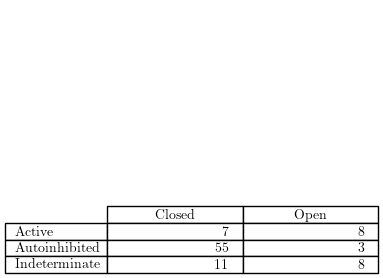

In [81]:
# Find the lowest 2_comp RMSD for each uniprot and keep the PDB identifier
min2Comp = clSub.groupby('Uniprot')[['PDB', 'IM on FD']].min().reset_index()

# Merge the minimum 2_comp RMSD with the original data to get state and conformation
minState = min2Comp.merge(cl[['uniprot', 'pdb', 'state', 'conformation']], left_on='PDB', right_on='pdb')

# Assign predicted structure state. Use state if less than 15 RMSD, otherwise it's 'indeterminate'
minState['predicted_state'] = np.where(minState['IM on FD'] < 15, minState['state'], 'Indeterminate')

# Now let's count the number of proteins in each predicted state and conformation
counts = minState.groupby(['predicted_state', 'conformation']).size().reset_index()
counts.columns = ['Predicted State', 'Conformation', 'Count']

# Let's do it only by predicted state
stateCounts = minState.groupby('predicted_state').size().reset_index()
stateCounts.columns = ['Predicted State', 'Count']

# Let's plot these as tables
ax = plt.subplot(111, frame_on=False)
table(ax, counts.pivot('Predicted State', 'Conformation', 'Count'))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Plot the other one
# ax = plt.subplot(111, frame_on=False)
# table(ax, stateCounts)
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)

Now let's make the same plots and tables as above for proteins with experimental structures in both states. We'll figure this out _de novo_.

In [82]:
# Determine which proteins from cl have both active and autoinhibited structures
both = cl.groupby('uniprot').filter(lambda x: x['state'].nunique() > 1)

# Format the data for plotting
bothSub = both[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]
bothSub.columns = ['Uniprot', 'PDB', 'Autoinhibitory Protein Structure', 'IM on IM', 'FD on FD', 'IM on FD']
bothPlot = pd.melt(bothSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')
bothPlot['RMSD'] = bothPlot['RMSD'].astype(float)
bothPlot = bothPlot[bothPlot['RMSD'] < 100]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory Protein Structure vs. IM on IM: Mann-Whitney-Wilcoxon test two-sided, P_val:8.295e-02 U_stat=2.616e+04
IM on IM vs. FD on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.294e-58 U_stat=5.333e+04
FD on FD vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.084e-73 U_stat=1.275e+03
Autoinhibitory Protein Structure vs. FD on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.770e-57 U_stat=5.347e+04
IM on IM vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:7.955e-17 U_stat=1.614e+04
Autoinhibitory Protein Structure vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.424e-16 U_stat=1.641e+04


(<Axes: title={'center': 'Distributions of RMSD values of structural alignments for 2-state proteins'}, xlabel='Alignment', ylabel='RMSD'>,
  <statannotations.Annotation.Annotation at 0x7fcdb823c890>])

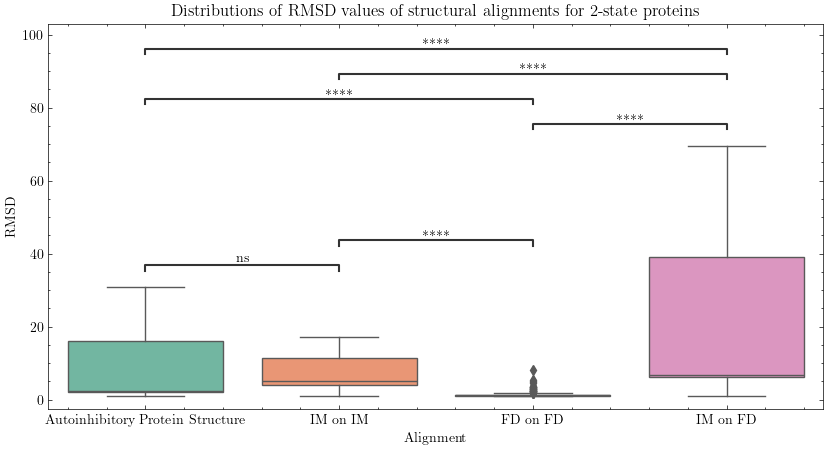

In [84]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=bothPlot, x='Alignment', y='RMSD', ax=ax, palette='Set2')
ax.set_title('Distributions of RMSD values of structural alignments for 2-state proteins')

# Add the annotations
pairs = [('Autoinhibitory Protein Structure', 'IM on IM'),
         ('Autoinhibitory Protein Structure', 'FD on FD'),
         ('Autoinhibitory Protein Structure', 'IM on FD'),
         ('IM on IM', 'FD on FD'),
         ('IM on IM', 'IM on FD'),
         ('FD on FD', 'IM on FD')]
order = ['Autoinhibitory Protein Structure', 'IM on IM', 'FD on FD', 'IM on FD']
annotator = Annotator(ax, pairs, data=bothPlot, x='Alignment', y='RMSD', order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

/tmp/ipykernel_2114225/2285721701.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table(ax, bothCounts.pivot('Predicted State', 'Conformation', 'Count'))


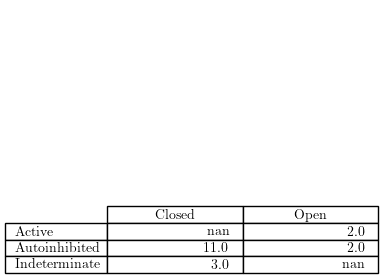

In [88]:
# Now we make the table
bothMin = both.groupby('uniprot')[['pdb', '2_comp']].min().reset_index()

# Merge the minimum 2_comp RMSD with the original data to get state and conformation
bothState = bothMin.merge(both[['uniprot', 'pdb', 'state', 'conformation']], on='pdb')

# Assign predicted structure state. Use state if less than 15 RMSD, otherwise it's 'indeterminate'
bothState['predicted_state'] = np.where(bothState['2_comp'] < 15, bothState['state'], 'Indeterminate')

# Now let's count the number of proteins in each predicted state and conformation
bothCounts = bothState.groupby(['predicted_state', 'conformation']).size().reset_index()
bothCounts.columns = ['Predicted State', 'Conformation', 'Count']

# Make table
ax = plt.subplot(111, frame_on=False)
table(ax, bothCounts.pivot('Predicted State', 'Conformation', 'Count'))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)